## Table of contents:
* [Set env](#set_env)
* [General information on Reactome biopax file](#general_reactome)
    * [Query 1: Number of elements for each biopax types](#query1)
* [Complexes](#complexes)
    * [Complexes in BioPAX specifications](#complexes_in_biopax)
    * [Complexes in Reactome](#complex_reactome)
        * [Summary](#summary)
        * [Query 2: How many black-box complexes?](#query2) 
        * [Query 3: How many complexes have at least one component? ](#query3)
        * [Query 4: How many complexes have at least one component that is a complex? ](#query4)
        * [Query 5: How many complexes have at least one component, none of which is a complex? ](#query5)
        * [Query 6: How many complexes have at least one component that is a blackbox complex ](#query6)
        * [Query 7: How many complexes have at least one component that is a complex, and all its components that are complexes are actually black box complexes? ](#query7)
        * [Query 8: How many complexes have at least one component that is a complex, but not a black-box complex? ](#query8)
        * [Query 9: How many complexes, that are not black boxes, are a component of at least another complex? ](#query9)
        * [Query 10: Distribution of the number of direct components by complex ](#query10)  
        * [Query 11: Distribution of the number of complexes a complex is a component of](#query11)
        * [Query 12:  How many interactions directly involve an invalid complex? ?](#query12)
        * [Query 13: How many different components are involved in the invalid complexes?](#query13)
        * [Query 14: How many interactions directly involve a component of an invalid complex?](#query14)
        * [Query 15: How many interactions involve a complex having a direct component that is a component of an invalid complex?](#query15)
        * [Query 16: How many interactions directly and indirectly involve these components?](#query16)
    * [Fix the invalid complexes](#fix_complexes)
    * [Identify the redundant complexes](#identify_redundant)
        * [Query 17: How many pairs of complexes have different identifiers but the same components with the same stoichiometric coefficients and the same cellular localisation?](#query17)
        * [How many cliques?](#cliques)
    * [Evaluation of the benefits for graph computing](#modules)
        * [Query 18: How many ProteinReferences match the given list of HGNC/UniProt IDs?](#query18)
        * [Query 19: How many Proteins are linked to these ProteinReferences?](#query19)
        * [Query 20: How many interactions directly involve these Proteins?](#query20)
        * [Query 21: How many interactions indirectly involve these Proteins?](#query21)

        
        
        

### Environment <a class="anchor" id="set_env"></a>

In [1]:
import importlib
import json
import matplotlib.pyplot as plt
import os
import pandas
import rdflib
import rdflib.namespace
import sparqldataframe
import seaborn as sns
from SPARQLWrapper import SPARQLWrapper, JSON
import sys

In [2]:
reactomeVersion = 79
endpointURL = "http://localhost:3030/REACTOME/query"
rdfFormat = "turtle"

In [3]:
prefixes = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>

PREFIX chebi: <http://purl.obolibrary.org/obo/chebi/>
PREFIX chebidb: <http://purl.obolibrary.org/obo/CHEBI_>
PREFIX chebirel: <http://purl.obolibrary.org/obo/CHEBI#>

PREFIX up:<http://purl.uniprot.org/core/>
PREFIX udb: <http://purl.uniprot.org/database/>
PREFIX uniprot: <http://purl.uniprot.org/uniprot/>

PREFIX bp3: <http://www.biopax.org/release/biopax-level3.owl#>
PREFIX reactome: <http://www.reactome.org/biopax/79/48887#>
"""

### General information on the dataset (Reactome Biopax Homo Sapiens v79) <a class="anchor" id="general_reactome"></a>

Query 1: Number of elements for each biopax types <a class="anchor" id="query1"></a>

In [4]:
## Reactome - initial file
## Version xml:base="http://www.reactome.org/biopax/79/48887#"> (2022-02-03)

## Number of elements for each biopax types
query="""
# Number of elements for each biopax types in reactome
SELECT ?type (COUNT(DISTINCT(?element)) AS ?nb_elements)
WHERE {
  ?element a ?type.
  FILTER(STRSTARTS(STR(?type),str(bp3:)) )
}
GROUP BY ?type
ORDER BY DESC (?nb_elements)
"""
pandas.set_option("max_colwidth", 80)
df = sparqldataframe.query(endpointURL, prefixes+query)
df

,type,nb_elements
0,http://www.biopax.org/release/biopax-level3.owl#UnificationXref,161231
1,http://www.biopax.org/release/biopax-level3.owl#SequenceSite,62738
2,http://www.biopax.org/release/biopax-level3.owl#Stoichiometry,36907
3,http://www.biopax.org/release/biopax-level3.owl#Protein,31506
4,http://www.biopax.org/release/biopax-level3.owl#PublicationXref,30856
5,http://www.biopax.org/release/biopax-level3.owl#FragmentFeature,28183
6,http://www.biopax.org/release/biopax-level3.owl#SequenceInterval,28183
7,http://www.biopax.org/release/biopax-level3.owl#PathwayStep,16182
8,http://www.biopax.org/release/biopax-level3.owl#RelationshipXref,14965
9,http://www.biopax.org/release/biopax-level3.owl#Complex,14840


### Complexes <a class="anchor" id="complexes"></a>

#### Complexes in BioPAX specifications <a class="anchor" id="complexes_in_biopax"></a>

- **Complex** (BioPAX-level3 page 48)
    - physical product of an interaction
    - **complexes should not be defined recursively** (a complex should not be a component of another complex)
    - **exceptions are black box complexes** i.e. complexes in which the component property is empty
    - the `bp3:component` property
        - has domain: `bp3:Complex`
        - has range: `bp3:PhysicalEntity`, which subclasses are:
            - `bp3:Dna`
            - `bp3:Rna`
            - `bp3:Protein`
            - `bp3:Complex` warning: black box complexes only!
            - `bp3:SmallMolecule`
- **Black box complex**
- **Redundant complexes** are complexes having different identifiers, possibly from different databases but having the same chemical and physical properties
    - redundant complexes form equivalence classes

#### Complexes in Reactome <a class="anchor" id="complex_reactome"></a>
![](./2022_03_09_Complex_Biopax.png)

#### Summary <a class="anchor" id="summary"></a>
- complexes: 14840
- black box complexes: 858
- complexes that have at least one component: 13982
    - (complexes that are not black box complexes)
    - control: 14840-858=13982
    - they have up to 65 direct components
- complexes that have at least one component that is a complex: 6249
    - might be ok if all these components are black box complexes
    - 44.7% of 13982 
    - 42.1% of 14776 
    - control: complexes that have at least one component, none of which is a complex: 7733 (13982-6249=7733)
- complexes that have at least one component that is a black box complex: ~739~ 737
    - 11.8% of 6249 
- complexes that have at least one component that is a complex, and all its components that are complexes are actually black box complexes: ~517~ 515 
    - was expecting more, ideally 6249 
    - 8.2% of 6249 
- complexes that have at least one component that is a complex but not a black box complex: ~5710~ 5734
    - **these complexes should be fixed**
    - 38.6% of 14840
    - 41% of 13982
- complexes that are not black boxes but are a component of at least another complex: 4333
    - **they are the ones to look at for fixing the 5734**
    - they can be valid (i.e. all their components that are complexes are black box complexes) or invalid
    - they can be involved in chemical reactions (and therefore we should keep them, possibly after making them compliant and after detecting redundancies) or not (and these we can probably discard)
    -  ~1032~  of them are the direct component of more than one complex (max = direct component of 65 complexes)

Query 2: How many black-box complexes? <a class="anchor" id="query2"></a>

In [5]:
## OD
query="""
# Blackbox complexes

SELECT (COUNT(DISTINCT ?complexBB) AS ?nbComplexesBB)
WHERE {
  ?complexBB rdf:type bp3:Complex .
  FILTER NOT EXISTS {
    ?complexBB bp3:component ?complexComponent . 
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexesBB
0,858


Query 3: How many complexes have at least one component? <a class="anchor" id="query3"></a>

In [6]:
## OD
query="""
# Complexes that have at least one component
# i.e. complexes that are not blackbox complexes

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,13982


Query 4: How many complexes have at least one component that is a complex? <a class="anchor" id="query4"></a>

In [7]:
## OD
query="""
# Complexes that have at least one component that is a complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,6249


Query 5: How many complexes have at least one component, none of which is a complex? <a class="anchor" id="query5"></a>

In [8]:
## OD
query="""
# Complexes that have at least one component, none of which is a complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  FILTER NOT EXISTS {
    ?complex bp3:component ?someComplexComponent . 
    ?someComplexComponent rdf:type bp3:Complex .
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,7733


Query 6: How many complexes have at least one component that is a blackbox complex  <a class="anchor" id="query6"></a>

In [9]:
## OD
query="""
# Complexes that have at least one component that is a blackbox complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
  FILTER NOT EXISTS {
    ?complexComponent bp3:component ?someComplexComponent . 
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,737


Query 7: How many complexes have at least one component that is a complex, and all its components that are complexes are actually black box complexes? <a class="anchor" id="query7"></a>

In [10]:
## OD
query="""
# Complexes that have at least one component that is a complex, 
# and all its components that are complexes are actually black box complexes

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
  FILTER NOT EXISTS {
    ?complex bp3:component ?someComplexComponent . 
    ?someComplexComponent rdf:type bp3:Complex .
    ?someComplexComponent bp3:component ?someComplexComponentComponent .
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,515


Query 8: How many complexes have at least one component that is a complex, but not a black-box complex? <a class="anchor" id="query8"></a>

Number of invalid complexes

In [11]:
## OD
query="""
# All invalid complexes
# Complexes that have at least one component that is a complex, but not a black box complexes

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
  ?complexComponent bp3:component ?someComplexComponentComponent .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,5734


Query 9: How many complexes, that are not black-boxes, are a component of at least another complex? <a class="anchor" id="query9"></a>

In [12]:
## OD
query="""
# Complexes that are not black boxes but are a component of at least another complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  
  ?superComplex bp3:component ?complex .
  ?superComplex rdf:type bp3:Complex .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,4333


Query 10: Distribution of the number of direct components by complex <a class="anchor" id="query10"></a>

In [13]:
## OD
query="""
# Distribution of the number of direct components by complex

SELECT ?complex (COUNT(DISTINCT ?complexComponent) AS ?nbComponents)
WHERE {
  {
    ?complex rdf:type bp3:Complex .
    ?complex bp3:component ?complexComponent . 
  }
  UNION
  {
    ?complex rdf:type bp3:Complex .
    FILTER NOT EXISTS {
      ?complex bp3:component ?complexComponent . 
    }
  }
}
GROUP BY ?complex
#ORDER BY DESC(?nbComponents)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df["nbComponents"] = pandas.to_numeric(df["nbComponents"])
#df.to_csv("./direct_components.csv")
df["nbComponents"].describe()

count    14840.000000
mean         2.243194
std          2.621832
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max         65.000000
Name: nbComponents, dtype: float64

Text(0.5, 0.98, 'Distribution of the number of direct components by complex')

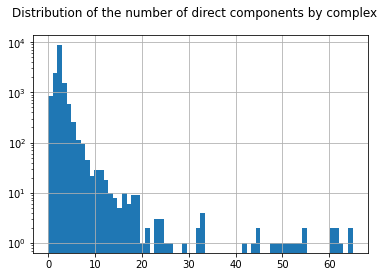

In [14]:
df['nbComponents'].hist(bins=df['nbComponents'].max()+1, log=True)
plt.suptitle("Distribution of the number of direct components by complex")

Query 11: Distribution of the number of complexes a complex is a component of<a class="anchor" id="query11"></a>

Text(0.5, 0.98, 'Distribution of the number of complexes a complex is a component of')

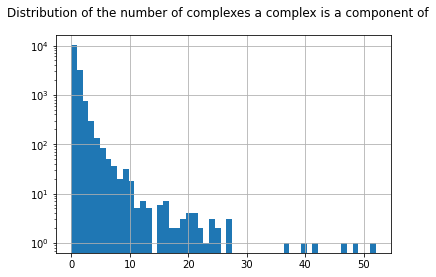

In [15]:
## OD
query="""
# Distribution of the number of complexes a complex is a component of

SELECT ?complex (COUNT(DISTINCT ?whole) AS ?nbWholes)
WHERE {
  {
    ?complex rdf:type bp3:Complex .
    ?whole bp3:component ?complex . 
  }
  UNION
  {
    ?complex rdf:type bp3:Complex .
    FILTER NOT EXISTS {
      ?whole bp3:component ?complex .
    }
  }
}
GROUP BY ?complex
#ORDER BY DESC(?nbComponents)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df["nbWholes"] = pandas.to_numeric(df["nbWholes"])
df["nbWholes"].describe()
df["nbWholes"].hist(bins=df['nbWholes'].max()+1, log=True)
plt.suptitle("Distribution of the number of complexes a complex is a component of")

Query 12: How many interactions **directly** involve invalid complexes? <a class="anchor" id="query12"></a>

In [16]:
## CJ
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
SELECT (COUNT(DISTINCT ?interaction) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent . 
  ?invalidComplexComponent rdf:type bp3:Complex .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?rel rdfs:subPropertyOf* bp3:participant . 
  ?interaction ?rel ?complex .
  
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,21813


Query 13: How many different components (proteins, small molecules et physical entites) are involved in the invalid complexes? <a class="anchor" id="query13"></a>

In [17]:
## CJ
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
SELECT (COUNT(DISTINCT ?leafComponent) AS ?nbInvalidComplexesComponents)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent . 
  ?invalidComplexComponent rdf:type bp3:Complex .
  ?invalidComplexComponent bp3:component ?someComplexComponentComponent .
  
  ?invalidComplex bp3:component+ ?leafComponent .
  
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .}
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInvalidComplexesComponents
0,7119


The 5,734 invalid complexes are (in)directly composed of 7,119 distinct entities that are not complexes, interactions, DNA or RNA. Nb: this excludes black-box complexes.

Query 14: How many interactions **directly** involve these components? <a class="anchor" id="query14"></a>

In [18]:
## CJ OD
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
#All interactions that have a participant that is a component of an invalid complex 

SELECT (COUNT(DISTINCT ?interact) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?invalidComplex bp3:component* ?leafComponent .

  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .} 
  
  ?interact ?hasParticipant ?leafComponent .
  ?hasParticipant rdfs:subPropertyOf* bp3:participant .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,7832


Query 15: How many interactions involve a complex having a **direct** component that is a component of an invalid complex?  <a class="anchor" id="query15"></a>

Interactions involving a complex composed directly of a component of an invalid complex

In [19]:
query="""
# All interactions that have a participant that is a complex having a direct component that is a component of an invalid complex (excludes black-box complexes)

SELECT (COUNT(DISTINCT ?interact) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?invalidComplex bp3:component* ?leafComponent .

  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .}
  
  ?interactParticipant bp3:component? ?leafComponent . # 0 or 1 path
  ?interact ?hasParticipant ?interactParticipant .
  ?hasParticipant rdfs:subPropertyOf* bp3:participant .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,12148


Query 16: How many interactions **directly** and **indirectly** involve these components? <a class="anchor" id="query16"></a>

Interactions involving a complex (valid or invalid) composed indirectly of a component of an invalid complex or the component itself

In [20]:
## CJ OD
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
#Interactions involving a complex composed indirectly of a component of an invalid complex

SELECT (COUNT(DISTINCT ?interact) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?invalidComplex bp3:component* ?leafComponent .
  
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .}
  
  
  ?interactParticipant bp3:component* ?leafComponent . # 0 or more paths
  ?hasParticipant rdfs:subPropertyOf* bp3:participant .  
  ?interact ?hasParticipant ?interactParticipant .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,13211


### Fix the invalid complexes <a class="anchor" id="fix_complexes"></a>

![]("./Figure_drawio/2022_03_17_Stoichio.pdf")

Query: <a class="anchor" id="query"></a>

### Identify the redundant complexes <a class="anchor" id="identify_redundant"></a>

Query 17: How many pairs of complexes have different identifiers but the same components with the same stoichiometric coefficients and the same cellular location? <a class="anchor" id="query17"></a>

In [22]:
## OD CJ
query = """
# Retrieve redundant complexes i.e. pairs of complexes having different identifiers but the same components with the same stoichiometric coefficients
SELECT DISTINCT ?complex1  ?complex2 # ?id1 ?id2 #?comp ?stoichioValue1 ?stoichioValue2

WHERE {
  #VALUES ?complex { reactome:Complex3 reactome:Complex7 reactome:Complex4 reactome:Complex5 reactome:Complex6 reactome:Complex8 reactome:Complex101 reactome:Complex102 }
  #VALUES ?complex { reactome:Complex102 }
  
  ?complex1 rdf:type bp3:Complex .
  # ?complex1 and ?complex2 have at least 1 common component (to avoid matching all the pairs of blackbox complexes that do not have any components)
  ?complex1 bp3:component ?commonComp .
  ?complex2 bp3:component ?commonComp .
  ?complex2 rdf:type bp3:Complex .
  ?complex1 bp3:cellularLocation ?loc1 .
  ?complex2 bp3:cellularLocation ?loc1 .
  FILTER (str(?complex1) < str(?complex2))
  # ?complex1 and ?complex2 do not have any common component that has different stoichiometric coefficients between the two complexes
  FILTER NOT EXISTS {
    ?complex1 bp3:component ?comp .
    ?complex2 bp3:component ?comp .
    #?complex1 bp3:cellularLocation ?loc1 .
    ?complex1 bp3:componentStoichiometry ?stoichio1 .
    ?stoichio1 bp3:physicalEntity ?comp .
    ?stoichio1 bp3:stoichiometricCoefficient ?stoichioValue1 .

    ?complex2 bp3:componentStoichiometry ?stoichio2 .
    ?stoichio2 bp3:physicalEntity ?comp .
    #?complex2 bp3:cellularLocation ?loc2 .
    ?stoichio2 bp3:stoichiometricCoefficient ?stoichioValue2 .
    FILTER (?stoichioValue1 != ?stoichioValue2)
    #FILTER (?loc1 != ?loc2)
  }


  # all the direct components of ?complex1 are also components of ?complex2
  FILTER NOT EXISTS {
    ?complex1 bp3:component ?comp1 .
    FILTER NOT EXISTS {
      ?complex2 bp3:component ?comp1 .
    }
  }
  # all the direct components of ?complex2 are also components of ?complex1
  FILTER NOT EXISTS {
    ?complex2 bp3:component ?comp2 .
    FILTER NOT EXISTS {
      ?complex1 bp3:component ?comp2 .
    }
  }
 OPTIONAL{ ?complex1 bp3:xref ?xref1 .
    ?xref1 bp3:db "ComplexPortal" .
    ?xref1 bp3:id ?id1 . }
  
OPTIONAL{ ?complex2 bp3:xref ?xref2 .
    ?xref2 bp3:db "ComplexPortal" .
    ?xref2 bp3:id ?id2 . }
}
"""
df = sparqldataframe.query(endpointURL, prefixes+query)
df

,complex1,complex2
0,http://www.reactome.org/biopax/79/48887#Complex21,http://www.reactome.org/biopax/79/48887#Complex777
1,http://www.reactome.org/biopax/79/48887#Complex22,http://www.reactome.org/biopax/79/48887#Complex763
2,http://www.reactome.org/biopax/79/48887#Complex118,http://www.reactome.org/biopax/79/48887#Complex14143
3,http://www.reactome.org/biopax/79/48887#Complex209,http://www.reactome.org/biopax/79/48887#Complex210
4,http://www.reactome.org/biopax/79/48887#Complex278,http://www.reactome.org/biopax/79/48887#Complex279
...,...,...
128,http://www.reactome.org/biopax/79/48887#Complex13360,http://www.reactome.org/biopax/79/48887#Complex13371
129,http://www.reactome.org/biopax/79/48887#Complex13674,http://www.reactome.org/biopax/79/48887#Complex14509
130,http://www.reactome.org/biopax/79/48887#Complex14477,http://www.reactome.org/biopax/79/48887#Complex4074
131,http://www.reactome.org/biopax/79/48887#Complex14640,http://www.reactome.org/biopax/79/48887#Complex14641


How many cliques? <a class="anchor" id="cliques"></a>

In [23]:
cliques = {df["complex1"][0] : [df["complex2"][0]]}
for row in df.itertuples(index=False):
    if row[0] in cliques :
        cliques[row[0]].append(row[1])
    elif row[1] in cliques :
        cliques[row[1]].append(row[0])
    else :
        found = False
        for i in cliques :
            if row[0] in cliques[i]:
                cliques[i].append(row[1])
                found = True
                break
            elif row[1] in cliques[i]:
                cliques[i].append(row[0])
                found = True
                break
        if not found :
            cliques[row[0]] = list()
            cliques[row[0]].append(row[1])
       
len(cliques) 

117

### Evaluation for determining the reactions a molecule participates to <a class="anchor" id="modules"></a>
"To evaluate the benefit of the procedure, we considered eight modules of 7 to 67 unique transcripts of genes (Table 2). 
These modules were initially identified from an experimental microarray thanks to 
hted gene co-expression network analysis \cite{Langfelder2008} describing the correlation patterns among genes across microarray samples, and related to a phenotype of interest in animal production. 
From these experimental modules, we wanted to retrieve all interactions in the corresponding genes (transcripts or encoded proteins) were involved. 
Here, we compared the number of interactions found when identifying proteins from one of the modules as a direct participant, as the direct component of a complex that was a direct participant (no correction) and as the direct component of a complex  after fixing and validation (i.e. when considering invalid complexes)."

* todo : récupérer directement les ID uniprot correspondant

In [24]:
module3 = '"ACAN" "ACVR2B" "ZUFSP" "TM4SF18" "PRKCE" "CHCHD3" "IGDCC3" "GABBR2" "DGKA" "AFF1" "HTR7" "KIAA0247" "PROX1" "LOC102158595" "C8orf37" "RSF1" "TBC1D19" "MTUS2" "LUM" "SMTN" "LDB3" "LOC102162623" "HRH1" "TMEM14C" "FST" "TBR1" "GSK3A"'
module4 = '"DNAJB9" "WBSCR27" "LOC396781" "SERHL2" "CCR10" "CACNG5" "TNFRSF17" "SRM" "DERL3" "RFC3" "TAOK3" "CLDN3" "IGLL5" "BMP6" "LOC524810" "IGHA" "LOC100037924" "IGL" "BCL2A1" "IGLV-10" "PADI2" '
module8 = '"TMEM161B" "IZUMO4" "ZNF791" "ANO9" "DPP4" "PPP1R26" "BEX4" "RRAGD" "RASGEF1B" "CD3G" "STRN" "TGFBR3" "GATA3" "PLVAP" "TNFRSF16" "NIPSNAP3B" "KCTD12" "CD3E" "LOC101903221" "SLC4A11" "CD3D" "KATNA1" "SLC22A17" "FMNL3" "SOX4" "CCR7" "ID3" "ZCCHC10" "EEPD1" "SLC25A13" "F8" "SLC27A3" "ARHGEF16" "ETNK2" "SH3BP4" "SPATA21" "FCER1A" "LAT" "MYO10" "ENC1" "CDH24" "LOC100154277" "EZR" "PTTG1" "PRUNE2" "PCYOX1L" "CD247" "CCDC86" "LOC100621726" "FGFR1OP2" "PLEKHH1" "C2H19orf42" "LOC100738180" "DSN1" "TOMM34" "PLXND1" "IFT80" "SYTL3" "NIPSNAP3A" "GRAP2" "POFUT1" "P311" "UBE2J1" "FYN" "SKAP1" "BLK" "LOC100627089" "ACVR2A" "ZAP70" "EPHB6" "DTNB" "C1orf186" "L1CAM" "TCF12" "EPHA7" "ITGAV" "SLC4A4" "NPY" "CATSPERG" "LPAR3" "SEPT6" '
module5 = '"MUC4" "PTGS1" "HSP70.2" "SLPI" "RNF39" "TR10D" "AXL" "ZNF7" "MED8" "LOC100627004" "P2RY1" "C15H11orf96" "BAG3" "HLA-E" "HSPA1B" "TRIM26"'
module2 = '"JPH4" "ZFAND6" "RPL38" "LOC102166814" "UBP30" "PFN1" "EIF1B" "FXYD6" "LOC100737327" "FBXO30" "Il6st" "ZNF451" "TTC21A" "SLC35A5" "SLCO2B1" "LOC100622689" "RNF14" "RPL14" "FAM171A2" "SLC22A15" "CCR3" "SYNGAP1" "KIAA1644" "LOC102164756" "GNMT" "CWF19L2" "ATP6V1C2" "C8orf37" "ITSN1" "PREX1" "TMEM52B" "TXLNB" "RAB23" "RPL35" "KRTCAP3" "POLB" "WWP1" "PGBD1" "SLC46A2" "PCIF1" "E4" "ENO3" "CD300C" "FAM102A" "ANAPC4" "YWHAZ" "PIGL" "PLCD4" "PLA2G12A" "DHX33" "CAPSL" "ARID3B" "RGL2"'
module7 = '"LOC100513097" "PSMB8" "TUBB6" "SLA-DRB1" "ADM" "PERP" "GLI2" "PCK2" "NCR3" "GLO1" "PTGER3" "LOC100516920" "SLA-7"'
module6 = '"SLA-1" "LOC102161909" "CLU" "SLA-3" "TINF2" "SLC12A1" "PXMP2" "EI24" "PSME2" "UQCC2" "H2-Q4" "LOC100515902" "LOC100515735" "SLA3" "GMPR2" "LOC100622689" "SNUPN" "SLA-DQA1" "EMC9" "LOC100522150" "SLA-2" "LOC100622791" "SLA-5" '
module1 = '"FCRLA" "GFRA1" "ANKRD42" "RYBP" "ITGB5" "SLA-DRB1" "BCL2" "TRAF3IP2" "DCTD" "CD79A" "DECR1" "AGMAT" "LY86" "TLR1" "KLK1" "SLC5A4" "LOC100524883" "CD40" "ELL3" "AMIGO2" "PIKFYVE" "TMEM163" "ORAOV1" "ABCA3" "C6H16orf74" "PRDX5" "CAND2" "SIN3A" "ANGPTL4" "FCGR2B" "CD302" "F12" "CCS" "HIP1R" "ZBTB32" "TLR10" "DDC" "CHCHD10" "ZNRF3" "NXN" "DACT3" "XKRX" "COBLL1" "CYAC3" "CYSTM1" "SLC34A3" "SLA-DOA" "CD19" "CD180" "SYK" "MS4A1" "C17H20orf106" "SLA-DQA1" "DSE" "ZKSCAN1" "IL4I1" "CLCN6" "EBF1" "TCF4" "CBFA2T3" "SLA-DOB" "GCK" "ZBTB44" "VAV2" "CD1.1" "VPREB3" "SLC35D2" "PCMTD1" "CYB5B" "LOC100130458" "SPIB" "SREBF2" "STX7" "Mef2c" "MLX" "MYBL1" "C1H9orf9" "HTRA1" "SLC23A1" "NDUFB9" "BLNK" "DNMBP" "MYOF" "BHLHE41" "CD72" "TPD52" "HMG20A" "SLA-DRA" "IGLV-4" "IL11RA" "GZMH" "SERPINF2" "POU2AF1" "CD79B" "IGHD" "LAMP3" "LOC102158858" "C4BPB" "BCL9L" "KIAA0556" "ITGAD" "N4BP2L1" "UHRF1BP1L" "CAMK2N1" "GLIS2" "SHISA2" "LIMD1" "PGAM2" "DTNBP1" "RALGPS2" "FCRL1" "CBR3" "LHCGR" "LOC100620852"'

In [25]:
current = module1

Query 18: How many ProteinReferences match the given list of HGNC/UniProt IDs? <a class="anchor" id="query18"></a>

In [26]:
query = """
SELECT DISTINCT * #?interaction ?interName ?rel ?p ?pType ?pName ?complexPart ?complexPartType ?complexPartName

WHERE {

  SERVICE <https://sparql.uniprot.org/sparql> {
    VALUES ?hgncName {  """+ current + """ }
    ?hgnc rdf:type up:Resource .
    ?hgnc up:database udb:HGNC .
    ?hgnc rdfs:comment ?hgncName .

    ?uniprotID rdfs:seeAlso ?hgnc .
    ?uniprotID rdf:type up:Protein .
    ?uniprotID up:reviewed "true"^^xsd:boolean .
  }

 BIND (REPLACE(STR(?uniprotID), "http://purl.uniprot.org/uniprot/", "") AS ?localUniprotID)

 ?xref bp3:id ?localUniprotID .
 ?xref bp3:db "UniProt" .
  ?protref bp3:xref ?xref .
  ?protref rdf:type bp3:ProteinReference .
}  
"""
df = sparqldataframe.query(endpointURL, prefixes+query)
df

,hgncName,hgnc,uniprotID,localUniprotID,xref,protref
0,TPD52,http://purl.uniprot.org/hgnc/12005,http://purl.uniprot.org/uniprot/P55327,P55327,http://www.reactome.org/biopax/79/48887#UnificationXref13693,http://www.reactome.org/biopax/79/48887#ProteinReference1527
1,DECR1,http://purl.uniprot.org/hgnc/2753,http://purl.uniprot.org/uniprot/Q16698,Q16698,http://www.reactome.org/biopax/79/48887#UnificationXref96098,http://www.reactome.org/biopax/79/48887#ProteinReference8206
2,UHRF1BP1L,http://purl.uniprot.org/hgnc/29102,http://purl.uniprot.org/uniprot/A0JNW5,A0JNW5,http://www.reactome.org/biopax/79/48887#UnificationXref46495,http://www.reactome.org/biopax/79/48887#ProteinReference4111
3,CYB5B,http://purl.uniprot.org/hgnc/24374,http://purl.uniprot.org/uniprot/O43169,O43169,http://www.reactome.org/biopax/79/48887#UnificationXref108811,http://www.reactome.org/biopax/79/48887#ProteinReference9081
4,HIP1R,http://purl.uniprot.org/hgnc/18415,http://purl.uniprot.org/uniprot/O75146,O75146,http://www.reactome.org/biopax/79/48887#UnificationXref13656,http://www.reactome.org/biopax/79/48887#ProteinReference1517
...,...,...,...,...,...,...
62,NDUFB9,http://purl.uniprot.org/hgnc/7704,http://purl.uniprot.org/uniprot/Q9Y6M9,Q9Y6M9,http://www.reactome.org/biopax/79/48887#UnificationXref102470,http://www.reactome.org/biopax/79/48887#ProteinReference8596
63,GZMH,http://purl.uniprot.org/hgnc/4710,http://purl.uniprot.org/uniprot/P20718,P20718,http://www.reactome.org/biopax/79/48887#UnificationXref66756,http://www.reactome.org/biopax/79/48887#ProteinReference6213
64,SYK,http://purl.uniprot.org/hgnc/11491,http://purl.uniprot.org/uniprot/P43405,P43405,http://www.reactome.org/biopax/79/48887#UnificationXref40884,http://www.reactome.org/biopax/79/48887#ProteinReference3553
65,CD72,http://purl.uniprot.org/hgnc/1696,http://purl.uniprot.org/uniprot/P21854,P21854,http://www.reactome.org/biopax/79/48887#UnificationXref145959,http://www.reactome.org/biopax/79/48887#ProteinReference10447


Query 19: How many Proteins are linked to these ProteinReferences? <a class="anchor" id="query19"></a>

In [27]:
query = """
SELECT DISTINCT * #?interaction ?interName ?rel ?p ?pType ?pName ?complexPart ?complexPartType ?complexPartName

WHERE {

  SERVICE <https://sparql.uniprot.org/sparql> {
    VALUES ?hgncName {  """+ current + """ }
    ?hgnc rdf:type up:Resource .
    ?hgnc up:database udb:HGNC .
    ?hgnc rdfs:comment ?hgncName .

    ?uniprotID rdfs:seeAlso ?hgnc .
    ?uniprotID rdf:type up:Protein .
    ?uniprotID up:reviewed "true"^^xsd:boolean .
  }

 BIND (REPLACE(STR(?uniprotID), "http://purl.uniprot.org/uniprot/", "") AS ?localUniprotID)

 ?xref bp3:id ?localUniprotID .
 ?xref bp3:db "UniProt" .
  ?protref bp3:xref ?xref .
  ?protref rdf:type bp3:ProteinReference .
  ?prot bp3:entityReference ?protref .
}  
"""
df = sparqldataframe.query(endpointURL, prefixes+query)
df

,hgncName,hgnc,uniprotID,localUniprotID,xref,protref,prot
0,TPD52,http://purl.uniprot.org/hgnc/12005,http://purl.uniprot.org/uniprot/P55327,P55327,http://www.reactome.org/biopax/79/48887#UnificationXref13693,http://www.reactome.org/biopax/79/48887#ProteinReference1527,http://www.reactome.org/biopax/79/48887#Protein2845
1,TPD52,http://purl.uniprot.org/hgnc/12005,http://purl.uniprot.org/uniprot/P55327,P55327,http://www.reactome.org/biopax/79/48887#UnificationXref13693,http://www.reactome.org/biopax/79/48887#ProteinReference1527,http://www.reactome.org/biopax/79/48887#Protein2892
2,DECR1,http://purl.uniprot.org/hgnc/2753,http://purl.uniprot.org/uniprot/Q16698,Q16698,http://www.reactome.org/biopax/79/48887#UnificationXref96098,http://www.reactome.org/biopax/79/48887#ProteinReference8206,http://www.reactome.org/biopax/79/48887#Protein19944
3,UHRF1BP1L,http://purl.uniprot.org/hgnc/29102,http://purl.uniprot.org/uniprot/A0JNW5,A0JNW5,http://www.reactome.org/biopax/79/48887#UnificationXref46495,http://www.reactome.org/biopax/79/48887#ProteinReference4111,http://www.reactome.org/biopax/79/48887#Protein9630
4,CYB5B,http://purl.uniprot.org/hgnc/24374,http://purl.uniprot.org/uniprot/O43169,O43169,http://www.reactome.org/biopax/79/48887#UnificationXref108811,http://www.reactome.org/biopax/79/48887#ProteinReference9081,http://www.reactome.org/biopax/79/48887#Protein21129
...,...,...,...,...,...,...,...
124,SYK,http://purl.uniprot.org/hgnc/11491,http://purl.uniprot.org/uniprot/P43405,P43405,http://www.reactome.org/biopax/79/48887#UnificationXref40884,http://www.reactome.org/biopax/79/48887#ProteinReference3553,http://www.reactome.org/biopax/79/48887#Protein16273
125,SYK,http://purl.uniprot.org/hgnc/11491,http://purl.uniprot.org/uniprot/P43405,P43405,http://www.reactome.org/biopax/79/48887#UnificationXref40884,http://www.reactome.org/biopax/79/48887#ProteinReference3553,http://www.reactome.org/biopax/79/48887#Protein18308
126,SYK,http://purl.uniprot.org/hgnc/11491,http://purl.uniprot.org/uniprot/P43405,P43405,http://www.reactome.org/biopax/79/48887#UnificationXref40884,http://www.reactome.org/biopax/79/48887#ProteinReference3553,http://www.reactome.org/biopax/79/48887#Protein28991
127,CD72,http://purl.uniprot.org/hgnc/1696,http://purl.uniprot.org/uniprot/P21854,P21854,http://www.reactome.org/biopax/79/48887#UnificationXref145959,http://www.reactome.org/biopax/79/48887#ProteinReference10447,http://www.reactome.org/biopax/79/48887#Protein29675


Query 20: How many interactions **directly** involve these Proteins? <a class="anchor" id="query20"></a>

In [28]:
query = """
SELECT DISTINCT ?interaction #?rel ?p ?pType  ?complexPart ?complexPartType 
#?interName ?pName ?complexPartName
WHERE {

  SERVICE <https://sparql.uniprot.org/sparql> {
    VALUES ?hgncName { """+ current + """ }
    ?hgnc rdf:type up:Resource .
    ?hgnc up:database udb:HGNC .
    ?hgnc rdfs:comment ?hgncName .

    ?uniprotID rdfs:seeAlso ?hgnc .
    ?uniprotID rdf:type up:Protein .
    ?uniprotID up:reviewed "true"^^xsd:boolean .
  }

 BIND (REPLACE(STR(?uniprotID), "http://purl.uniprot.org/uniprot/", "") AS ?localUniprotID)

 ?xref bp3:id ?localUniprotID .
 ?xref bp3:db "UniProt" .
  ?protref bp3:xref ?xref .
  ?protref rdf:type bp3:ProteinReference .

       
  ?prot bp3:entityReference ?protref .
  ?interaction rdf:type/rdfs:subClassOf* bp3:Interaction .
  ?rel rdfs:subPropertyOf* bp3:participant . 
  ?interaction ?rel ?prot
}
"""
pandas.set_option("max_colwidth", 80)
df = sparqldataframe.query(endpointURL, prefixes+query)
df

,interaction
0,http://www.reactome.org/biopax/79/48887#BiochemicalReaction6972
1,http://www.reactome.org/biopax/79/48887#BiochemicalReaction6973
2,http://www.reactome.org/biopax/79/48887#BiochemicalReaction6976
3,http://www.reactome.org/biopax/79/48887#BiochemicalReaction12121
4,http://www.reactome.org/biopax/79/48887#BiochemicalReaction13466
5,http://www.reactome.org/biopax/79/48887#BiochemicalReaction6975
6,http://www.reactome.org/biopax/79/48887#Catalysis5504
7,http://www.reactome.org/biopax/79/48887#Catalysis5627
8,http://www.reactome.org/biopax/79/48887#BiochemicalReaction11950
9,http://www.reactome.org/biopax/79/48887#Catalysis2490


Query 21: How many interactions **indirectly** involve these Proteins? <a class="anchor" id="query20"></a>

In [29]:
query = """
SELECT DISTINCT ?interaction #?rel ?p ?pType  ?complexPart ?complexPartType 
#?interName ?pName ?complexPartName
WHERE {

  SERVICE <https://sparql.uniprot.org/sparql> {
    VALUES ?hgncName { """+ current + """ }
    ?hgnc rdf:type up:Resource .
    ?hgnc up:database udb:HGNC .
    ?hgnc rdfs:comment ?hgncName .

    ?uniprotID rdfs:seeAlso ?hgnc .
    ?uniprotID rdf:type up:Protein .
    ?uniprotID up:reviewed "true"^^xsd:boolean .
  }

 BIND (REPLACE(STR(?uniprotID), "http://purl.uniprot.org/uniprot/", "") AS ?localUniprotID)

 ?xref bp3:id ?localUniprotID .
 ?xref bp3:db "UniProt" .
  ?protref bp3:xref ?xref .
  ?protref rdf:type bp3:ProteinReference .

       
  ?prot bp3:entityReference ?protref .
  ?interaction rdf:type/rdfs:subClassOf* bp3:Interaction .
  ?rel rdfs:subPropertyOf* bp3:participant . 
  {
  	?interaction ?rel ?prot
  } UNION  {
  	?interaction ?rel ?complex .
  	?complex rdf:type bp3:Complex .
  	?complex bp3:component ?prot .
  }
  
  ?interaction ?rel ?p .
  OPTIONAL {?interaction bp3:displayName ?interName .}
  OPTIONAL {?p bp3:displayName ?pName .}
  ?p rdf:type ?pType .
  OPTIONAL {
    ?p rdf:type bp3:Complex .
    ?p bp3:component ?complexPart .
    ?complexPart bp3:displayName ?complexPartName .
    ?complexPart rdf:type ?complexPartType .
    }
}
"""
pandas.set_option("max_colwidth", 80)
df = sparqldataframe.query(endpointURL, prefixes+query)
df

,interaction
0,http://www.reactome.org/biopax/79/48887#Catalysis3161
1,http://www.reactome.org/biopax/79/48887#Catalysis4385
2,http://www.reactome.org/biopax/79/48887#BiochemicalReaction1028
3,http://www.reactome.org/biopax/79/48887#BiochemicalReaction1038
4,http://www.reactome.org/biopax/79/48887#BiochemicalReaction5003
...,...
159,http://www.reactome.org/biopax/79/48887#Catalysis5507
160,http://www.reactome.org/biopax/79/48887#BiochemicalReaction11461
161,http://www.reactome.org/biopax/79/48887#BiochemicalReaction11462
162,http://www.reactome.org/biopax/79/48887#BiochemicalReaction11463


Query: <a class="anchor" id="query"></a>